In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
%matplotlib inline

In [2]:
images=glob.glob('camera_cal/calibration*.jpg') #import glob of calibration images

objp = np.zeros((6*9,3), np.float32) #create np array for object points
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) #reshape and transpose array

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

for idx, fname in enumerate(images):
    img=cv2.imread(fname) #read each image
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #convert to grayscale
    
    ret,corners=cv2.findChessboardCorners(gray, (9,6),None) #returns if corners are found and corners
    
    if ret==True: #if corners found
        objpoints.append(objp) #add to object lists
        imgpoints.append(corners)

In [3]:
for i in range(20): #for all 20 images
    idx=i+1 #files are non-zero indexed
    idxS=str(idx) #turn identifier into string
    img=cv2.imread('camera_cal/calibration'+idxS+'.jpg') #read calibration image
    img_size = (img.shape[1], img.shape[0]) #get size of image

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_size,None,None) #get distortion parameters

    dst = cv2.undistort(img, mtx, dist, None, mtx) #undistort test images
    cv2.imwrite('camera_cal_undist/calibration'+idxS+'_undist.jpg',dst) #write to undistorted folder

In [4]:
#sample code for masking image given vertices

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [5]:
def hsl(img):
    """Applies the RGB to HSV Transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def scaled_sobel_thresh(img, orient='x', thresh=(0, 255),ksize=3):
    # Calculate directional gradient, scaled so that max is 255
    # Apply threshold
    
    if orient=='x': #if x is specified or nothing is specified
        sobel=np.absolute(cv2.Sobel(img,cv2.CV_64F,1,0,ksize)) #perform horizontal sobel operator
    else: #else perform in y direction
        sobel=np.absolute(cv2.Sobel(img,cv2.CV_64F,0,1,ksize))
    sobel=np.multiply(sobel,255.0/np.max(sobel)).astype(np.uint8)
    retV, thresh=cv2.threshold(sobel,thresh[0],thresh[1],cv2.THRESH_BINARY) #thresh is sobel with minimum threshold applied
    return thresh



In [6]:
def warp(img): #warps image so that parellel lane lines appear parallel
    img_size=(img.shape[1], img.shape[0])
    r_size=len(img) #get size of image
    c_size=len(img[0])
    
    #grab source points of parallel lines
    srcPts=np.float32([[(0.16*c_size-1,r_size-1),(0.84*c_size-1,r_size-1),(c_size*0.473-1,r_size*.62-1),(c_size*0.527-1,r_size*.62-1)]])
    
    #name destination points where source points will be warped
    dstPts=np.float32([[(0.325*c_size-1,r_size-1),(0.675*c_size-1,r_size-1),(0.325*c_size-1,0),(0.675*c_size-1,0)]])
    
    #get transformation matrix
    M=cv2.getPerspectiveTransform(srcPts,dstPts)
    return cv2.warpPerspective(img,M,img_size, flags=cv2.INTER_NEAREST) #return warped image using nearest neighbor interpolation

In [7]:
def warp_inv(img): #inverts warp transformation
    r_size=len(img) #get size of image
    c_size=len(img[0])
    #same as warp with destination and source points swapped
    dstPts=np.float32([[(0.16*c_size-1,r_size-1),(0.84*c_size-1,r_size-1),(c_size*0.473-1,r_size*.62-1),(c_size*0.527-1,r_size*.62-1)]])
    
    srcPts=np.float32([[(0.325*c_size-1,r_size-1),(0.675*c_size-1,r_size-1),(0.325*c_size-1,0),(0.675*c_size-1,0)]])
    
    M=cv2.getPerspectiveTransform(srcPts,dstPts)
    
    return cv2.warpPerspective(img,M,img_size, flags=cv2.INTER_NEAREST)

In [8]:
def process_frame(image,mtx,dst):
    #takes in image, undistorts the image, isolates saturation channel, performs thresholding, and warps
    
    r_size=len(img) #get size of image
    c_size=len(img[0])
    imageUD= cv2.undistort(image, mtx, dst, None, mtx) #undistort image

    hsl_img=hsl(imageUD)  # convert to HSL color space
    s=hsl_img[:,:,2] #isolate S channel
    satDiff=np.zeros_like(s) #create empty array that contains the difference in saturation values
    
    #long array that contains vertices for mask/region of interest
    vertices=np.array([[(int(c_size*1-1), r_size-1),(int(c_size*0.70-1),r_size-1),(int(c_size*0.5-1),int(r_size*.63)-1),(int(c_size*0.30-1),r_size-1),(int(c_size*0.00-1),r_size-1),(int(c_size*.42-1),int(r_size*0.62-1)),(int(c_size*.58-1),int(r_size*0.62-1))]])
    
    deltaX=35 #variable that is base for how wide numerical derivation will look
    
    
    for j in range(440,r_size): #for all rows 440 and below (the only ones that show up after warp)
        
        sAdd1=s[j,deltaX:c_size-deltaX].astype(np.float64)
        sAdd2=s[j,deltaX-1:c_size-deltaX-1].astype(np.float64)
        sAdd3=s[j,deltaX+1:c_size-deltaX+1].astype(np.float64)
        #three positive coefficients in finite differences
        
        sMinus1=s[j,0:c_size-2*deltaX].astype(np.float64)
        sMinus2=s[j,1:c_size-2*deltaX+1].astype(np.float64)
        sMinus3=s[j,2:c_size-2*deltaX+2].astype(np.float64)
        sMinus4=s[j,deltaX*2:c_size].astype(np.float64)
        sMinus5=s[j,deltaX*2-1:c_size-1].astype(np.float64)
        sMinus6=s[j,deltaX*2-2:c_size-2].astype(np.float64)
        #six negative coefficients in finite differences
        
        #calculates finite difference for interior cells in row j
        sSum=(sAdd1+sAdd2+sAdd3-0.5*(sMinus1+sMinus2+sMinus3+sMinus4+sMinus5+sMinus6))/3.0
        
        #for interior cells
        for i in range(c_size-deltaX*2):
            sDtemp=sSum[i] #temporary saturation difference is i-th entry in sSum
            
            #if less than zero
            if sDtemp<0:
                satDiff[j,i+deltaX]=0 #set to zero (images can't have negative values)
            else:
                satDiff[j,i+deltaX]=sDtemp #otherwise, positive value is retained
        
        #single-sided partial differences for left and ride side points 
        sAdd1=s[j,0:deltaX+1].astype(np.float64)
        sAdd2=s[j,1:deltaX+2].astype(np.float64)
        sAdd3=s[j,2:deltaX+3].astype(np.float64)
        sMinus1=s[j,deltaX:2*deltaX+1].astype(np.float64)
        sMinus2=s[j,deltaX-1:2*deltaX].astype(np.float64)
        sMinus3=s[j,deltaX-2:2*deltaX-1].astype(np.float64)
        sSum=(sAdd1+sAdd2+sAdd3-(sMinus1+sMinus2+sMinus3))/3.0
        
        for i in range(deltaX):
            sDtemp=sSum[i]
            if sDtemp<0:
                satDiff[j,i]=0
            else:
                satDiff[j,i]=sDtemp
        
        sAdd1=s[j,c_size-deltaX:c_size].astype(np.float64)
        sAdd2=s[j,c_size-deltaX-1:c_size-1].astype(np.float64)
        sAdd3=s[j,c_size-deltaX-2:c_size-2].astype(np.float64)
        sMinus1=s[j,c_size-deltaX*2:c_size-deltaX].astype(np.float64)
        sMinus2=s[j,c_size-deltaX*2+1:c_size-deltaX+1].astype(np.float64)
        sMinus3=s[j,c_size-deltaX*2+2:c_size-deltaX+2].astype(np.float64)
        sSum=(sAdd1+sAdd2+sAdd3-(sMinus1+sMinus2+sMinus3))/3.0
        
        for i in range(deltaX):
            sDtemp=sSum[i]
            if sDtemp<0:
                satDiff[j,i+c_size-deltaX]=0
            else:
                satDiff[j,i+c_size-deltaX]=sDtemp
            
    #scale saturation difference so that max is 255
    satDiff=satDiff*255.0/np.max(satDiff).astype(np.uint8)
    
    #perform scaled sobel transformation with threshold of 15
    sDsobel=scaled_sobel_thresh(satDiff,thresh=(15,255))
    
    #create combined image where saturation finite difference and scaled X sobel criteria are met
    combined=np.zeros_like(s)
    combined[(satDiff>20|(sDsobel>0))]=255
    
    #perform masking
    combined=region_of_interest(combined,vertices)
    
    #warp
    comWarp=warp(combined)           
    return comWarp
    

In [9]:
def process_frameNW(image,mtx,dst):
    #takes in image, undistorts the image, isolates saturation channel, performs thresholding, and DOES NOT warp
    
    r_size=len(img) #get size of image
    c_size=len(img[0])
    imageUD= cv2.undistort(image, mtx, dst, None, mtx) #undistort image

    hsl_img=hsl(imageUD)  # convert to HSL color space
    s=hsl_img[:,:,2] #isolate S channel
    satDiff=np.zeros_like(s) #create empty array that contains the difference in saturation values
    
    #long array that contains vertices for mask/region of interest
    vertices=np.array([[(int(c_size*1-1), r_size-1),(int(c_size*0.70-1),r_size-1),(int(c_size*0.5-1),int(r_size*.63)-1),(int(c_size*0.30-1),r_size-1),(int(c_size*0.00-1),r_size-1),(int(c_size*.42-1),int(r_size*0.62-1)),(int(c_size*.58-1),int(r_size*0.62-1))]])
    
    deltaX=35 #variable that is base for how wide numerical derivation will look
    
    
    for j in range(440,r_size): #for all rows 440 and below (the only ones that show up after warp)
        
        sAdd1=s[j,deltaX:c_size-deltaX].astype(np.float64)
        sAdd2=s[j,deltaX-1:c_size-deltaX-1].astype(np.float64)
        sAdd3=s[j,deltaX+1:c_size-deltaX+1].astype(np.float64)
        #three positive coefficients in finite differences
        
        sMinus1=s[j,0:c_size-2*deltaX].astype(np.float64)
        sMinus2=s[j,1:c_size-2*deltaX+1].astype(np.float64)
        sMinus3=s[j,2:c_size-2*deltaX+2].astype(np.float64)
        sMinus4=s[j,deltaX*2:c_size].astype(np.float64)
        sMinus5=s[j,deltaX*2-1:c_size-1].astype(np.float64)
        sMinus6=s[j,deltaX*2-2:c_size-2].astype(np.float64)
        #six negative coefficients in finite differences
        
        #calculates finite difference for interior cells in row j
        sSum=(sAdd1+sAdd2+sAdd3-0.5*(sMinus1+sMinus2+sMinus3+sMinus4+sMinus5+sMinus6))/3.0
        
        #for interior cells
        for i in range(c_size-deltaX*2):
            sDtemp=sSum[i] #temporary saturation difference is i-th entry in sSum
            
            #if less than zero
            if sDtemp<0:
                satDiff[j,i+deltaX]=0 #set to zero (images can't have negative values)
            else:
                satDiff[j,i+deltaX]=sDtemp #otherwise, positive value is retained
        
        #single-sided partial differences for left and ride side points 
        sAdd1=s[j,0:deltaX+1].astype(np.float64)
        sAdd2=s[j,1:deltaX+2].astype(np.float64)
        sAdd3=s[j,2:deltaX+3].astype(np.float64)
        sMinus1=s[j,deltaX:2*deltaX+1].astype(np.float64)
        sMinus2=s[j,deltaX-1:2*deltaX].astype(np.float64)
        sMinus3=s[j,deltaX-2:2*deltaX-1].astype(np.float64)
        sSum=(sAdd1+sAdd2+sAdd3-(sMinus1+sMinus2+sMinus3))/3.0
        
        for i in range(deltaX):
            sDtemp=sSum[i]
            if sDtemp<0:
                satDiff[j,i]=0
            else:
                satDiff[j,i]=sDtemp
        
        sAdd1=s[j,c_size-deltaX:c_size].astype(np.float64)
        sAdd2=s[j,c_size-deltaX-1:c_size-1].astype(np.float64)
        sAdd3=s[j,c_size-deltaX-2:c_size-2].astype(np.float64)
        sMinus1=s[j,c_size-deltaX*2:c_size-deltaX].astype(np.float64)
        sMinus2=s[j,c_size-deltaX*2+1:c_size-deltaX+1].astype(np.float64)
        sMinus3=s[j,c_size-deltaX*2+2:c_size-deltaX+2].astype(np.float64)
        sSum=(sAdd1+sAdd2+sAdd3-(sMinus1+sMinus2+sMinus3))/3.0
        
        for i in range(deltaX):
            sDtemp=sSum[i]
            if sDtemp<0:
                satDiff[j,i+c_size-deltaX]=0
            else:
                satDiff[j,i+c_size-deltaX]=sDtemp
            
    #scale saturation difference so that max is 255
    satDiff=satDiff*255.0/np.max(satDiff).astype(np.uint8)
    
    #perform scaled sobel transformation with threshold of 15
    sDsobel=scaled_sobel_thresh(satDiff,thresh=(15,255))
    
    #create combined image where saturation finite difference and scaled X sobel criteria are met
    combined=np.zeros_like(s)
    combined[(satDiff>20|(sDsobel>0))]=255
    
    #perform masking
    combined=region_of_interest(combined,vertices)
    return combined
    

In [10]:
def drawMidpoint(warped, al, bl, cl, ar, br, cr):
#draws fitted polynomials over the "midpoints" of sliding window search
#optionally, uses polynomial coefficients from last search if available
#if not available, set all coefficients to 0

    tempNomL=400 #best initial guess of left lane line position
    tempNomR=880 #best initial guess of right lane line position
    
    #empty lists to store "direction" of lane line
    lftIdx=[] 
    rtIdx=[]
    
    ploty=[] #y-positions for points to be fitted
    
    leftx=[] #x-positions for points to be fitted on left marker
    rightx=[] #x-positions for points to be fitted on left marker
    
    output=np.zeros_like(warped) #create empty output numpy array
    
    for i in range(5): #divide warped image into 5 horizontal slices
        bestSumL=0 #initialize maximum sums for left and right sliding windows, and index of maximum "windows"
        bestIdxL=-1
        bestSumR=0
        bestIdxR=-1
        
        for j in range(9): #try 9 siding windows
            tempNomNewL=tempNomL #set new temporary nominal positions to existing nominal positions
            tempNomNewR=tempNomR
            
            #get all binary threshold values in sliding windows
            subSet1=warped[720-(i+1)*144:719-i*144,tempNomL-10+(j-4)*20:tempNomL+10+(j-4)*20]
            subSet2=warped[720-(i+1)*144:719-i*144,tempNomR-10+(j-4)*20:tempNomR+10+(j-4)*20]
            
            #get sum of binary thresholds in sliding windows
            tempSumL=np.sum(subSet1)
            tempSumR=np.sum(subSet2)
            
            #if the left sliding window value is better than existing maximum, store value and index
            if tempSumL>bestSumL:
                bestSumL=tempSumL
                bestIdxL=j
                tempNomNewL=(bestIdxL-4)*20+tempNomL
                
            #if the right sliding window value is better than existing maximum, store value and index
            if tempSumR>bestSumR:
                bestSumR=tempSumR
                bestIdxR=j
                tempNomNewR=(bestIdxR-4)*20+tempNomR
        if bestIdxL==-1: #if no best window was found
            if i>0: #if this isn't the first slice from bottom
                bestIdxL=lftIdx[-1] #use last direction
            else: #else assume lane marker is straight ahead
                bestIdxL=4
            tempNomNewL=(bestIdxL-4)*20+tempNomL #calculate new nominal position for next iteration
        if bestIdxR==-1: #same for right window
            if i>0:
                bestIdxR=rtIdx[-1]
            else:
                bestIdxR=4
            tempNomNewR=(bestIdxR-4)*20+tempNomR
        
        if bestSumR<5000 and bestSumL>5000: #if there was little sum on the right, copy direction from left side
            bestIdxR=bestIdxL
            tempNomNewR=(bestIdxR-4)*20+tempNomR
            lftIdx.append(bestIdxL)
            rtIdx.append(bestIdxR)
        elif bestSumL<5000 and bestSumR>5000: #if there was little sum on the left, copy direction from right side
            bestIdxL=bestIdxR
            tempNomNewL=(bestIdxL-4)*20+tempNomL
            rtIdx.append(bestIdxR)
            lftIdx.append(bestIdxL)
        elif bestSumR<5000 and bestSumL<5000: #if neither sum was high enough, use last direction for both
            bestIdxL=lftIdx[-1]
            tempNomNewL=(bestIdxL-4)*20+tempNomL
            bestIdxR=rtIdx[-1]
            tempNomNewR=(bestIdxR-4)*20+tempNomR
            rtIdx.append(bestIdxR)
            lftIdx.append(bestIdxL)
        elif bestSumR>=5000 and bestSumL>=5000: #if both are good, add to list of directions
            rtIdx.append(bestIdxR)
            lftIdx.append(bestIdxL)
        
        #further sanity checks against dirverging or converging lanes
        if i>1: #only perform for 3rd, 4th and 5th slices
            if rtIdx[-1]>5: #if right lane is strongly right
                if rtIdx[-2]<4 and rtIdx[-2]!=-1: #if last lane marker was strongly left
                    rtIdx[-1]=rtIdx[-2] #assume right reading was noise, then continue left
                    bestIdxR=rtIdx[-2]
                    tempNomNewR=(bestIdxR-4)*20+tempNomR
            if rtIdx[-1]<4 and rtIdx[-1]!=-1: #if right lane is strongly left
                if rtIdx[-2]>5: #if last lane marker was strongly right
                    rtIdx[-1]=rtIdx[-2] #assume left reading was noise, then continue left
                    bestIdxR=rtIdx[-2]
                    tempNomNewR=(bestIdxR-4)*20+tempNomR
                    
            #repeat sanity checks for left lane
            if lftIdx[-1]>5:
                if lftIdx[-2]<4 and lftIdx[-2]!=-1:
                    lftIdx[-1]=lftIdx[-2]
                    bestIdxL=lftIdx[-2]
                    tempNomNewL=(bestIdxL-4)*20+tempNomL
            if lftIdx[-1]<4 and lftIdx[-1]!=-1:
                if lftIdx[-2]>5:
                    lftIdx[-1]=lftIdx[-2]
                    bestIdxL=lftIdx[-2]
                    tempNomNewL=(bestIdxL-4)*20+tempNomL
            
            
            #if percent difference of sum of directions grows too large
            if np.abs(np.sum(lftIdx[1:])-np.sum(rtIdx[1:]))>0.3*(np.sum(lftIdx[1:])+np.sum(rtIdx[1:])):
                if np.std(lftIdx[1:])>np.std(rtIdx[1:]): #if left is more trustworthy
                    rtIdx[-1]=lftIdx[-1] #use left direction
                    bestIdxR=rtIdx[-1]
                elif np.std(lftIdx[1:])<np.std(rtIdx[1:]): #otherwise use right direction
                    lftIdx[-1]=rtIdx[-1]
                    bestIdxL=lftIdx[-1]
        
        
        
       
        
        ploty.append(float(647-i*144)) #add y value to list
        leftx.append(float((bestIdxL-4)*20+tempNomL)) #add left x value to list
        rightx.append(float((bestIdxR-4)*20+tempNomR)) #add right x value to list
            
        tempNomNewL=(bestIdxL-4)*20+tempNomL #calculate new nominal starting position for left sliding window
        tempNomNewR=(bestIdxR-4)*20+tempNomR #and right too
        
        tempNomR=tempNomNewR #new becomes old nominal values
        tempNomL=tempNomNewL
        #end for loop
        
    if al!=0 or ar!=0 or bl!=0 or br!=0 or cl!=0 or cr!=0: #if any coefficients are non-zero
        left_fit = np.polyfit(ploty, leftx, 2) #calculate parabolic fit for left lane line
        right_fit = np.polyfit(ploty, rightx, 2) #for right too
        alRelDiff=np.abs((al-left_fit[0])/al) #calculate relative difference between new and old coefficients for left
        blRelDiff=np.abs((bl-left_fit[1])/bl)
        clRelDiff=np.abs((cl-left_fit[2])/cl)
        arRelDiff=np.abs((ar-right_fit[0])/ar) #and right
        brRelDiff=np.abs((br-right_fit[1])/br)
        crRelDiff=np.abs((cr-right_fit[2])/cr)
        maxRelDiff=max([alRelDiff,blRelDiff,clRelDiff,arRelDiff,brRelDiff,crRelDiff]) #find maximum relative percent difference
        if maxRelDiff<0.7: #if below 70% (non-troubling)
            left_fit[0]=left_fit[0]/2.0+al/2.0 #calculate new fit coefficients using even weighting between previous and new coefficients
            left_fit[1]=left_fit[1]/2.0+bl/2.0
            left_fit[2]=left_fit[2]/2.0+cl/2.0
            left_fitx = left_fit[0]*np.power(ploty,2.0) + np.multiply(left_fit[1],ploty)+left_fit[2] #calculate fitted left x-points
            right_fit[0]=right_fit[0]/2.0+ar/2.0 #repeat for right
            right_fit[1]=right_fit[1]/2.0+br/2.0
            right_fit[2]=right_fit[2]/2.0+cr/2.0
            right_fitx = right_fit[0]*np.power(ploty,2.0) + np.multiply(right_fit[1],ploty)+right_fit[2]
        else: #if relative difference is too high
            left_fit[0]=left_fit[0]/4.0+al*0.75 #weigh old fit to new fit 3:1
            left_fit[1]=left_fit[1]/4.0+bl*0.75
            left_fit[2]=left_fit[2]/4.0+cl*0.75
            left_fitx = left_fit[0]*np.power(ploty,2.0) + np.multiply(left_fit[1],ploty)+left_fit[2]
            right_fit[0]=right_fit[0]/4.0+ar*0.75
            right_fit[1]=right_fit[1]/4.0+br*0.75
            right_fit[2]=right_fit[2]/4.0+cr*0.75
            right_fitx = right_fit[0]*np.power(ploty,2.0) + np.multiply(right_fit[1],ploty)+right_fit[2]
    
    else: #if no previous coefficients are available use raw fits
        left_fit = np.polyfit(ploty, leftx, 2)
        left_fitx = left_fit[0]*np.power(ploty,2.0) + np.multiply(left_fit[1],ploty)+left_fit[2]
        right_fit = np.polyfit(ploty, rightx, 2)
        right_fitx = right_fit[0]*np.power(ploty,2.0) + np.multiply(right_fit[1],ploty)+right_fit[2]
        
    #plot fitted lines on warped image
    for i in range(300,720): #for all rows below row 300 (beyond 300 fits get slightly inaccurate)
        leftx=int(np.rint(left_fit[0]*i**2+left_fit[1]*i+left_fit[2])) #calculate left lane
        rightx=int(np.rint(right_fit[0]*i**2+right_fit[1]*i+right_fit[2])) #calculate right lane
        for j in range(25): #create lines 25 pixels wide
            if leftx+j-12>=0: #check that index is in bounds for left line
                output[i,leftx+j-12]=255 #turn on pixels
            if rightx+j-12<1280: #and check in-bounds for right line
                output[i,rightx+j-12]=255 #turn on pixels
        for k in range(leftx+13,rightx-12):
            output[i,k]=100
    
    al=left_fit[0] #output final fit coefficients
    bl=left_fit[1]
    cl=left_fit[2]
    ar=right_fit[0]
    br=right_fit[1]
    cr=right_fit[2]
    
    return output, al, bl, cl, ar, br, cr

In [11]:
def curvature(al,bl,ar,br,ypos): #calculate radius of curvature at bottom of screen in feet
    #al, bl, ar, and br are the linear and quadratic coefficents
    #ypos is the pixel at which the curvature is calculated
    
    scale=12/480 #lane width is about 480 pixels, and standard lane width is 12 feet.
    lCurveInit=np.median(np.power(1+np.power(2*np.multiply(al,ypos)+bl,2),1.5)/np.abs(2*al))
    #calculate radius of curvature of left lane
    
    #calculate radius of curvature of right lane
    rCurveInit=np.median(np.power(1+np.power(2*np.multiply(ar,ypos)+br,2),1.5)/np.abs(2*ar))
    mCurveInit=min([lCurveInit,rCurveInit]) #return minimum radius of curvature in feet
    return mCurveInit

In [12]:
def laneOffset(al, bl, cl, ar, br, cr,c_size): #calculate offset in lane
    #al, bl, cl, ar, br, and cr are the quadratic coefficents
    #c_size is the height of image in pixels
    #returns positive numbers when the lane centerline is right of center, or when vehicle is left in lane
    
    scale=12/480 #lane width is about 480 pixels, and standard lane width is 12 feet.
    leftx=al*c_size**2+bl*c_size+cl #calculate x-position of left lane 
    rightx=ar*c_size**2+br*c_size+cr #calculate x-pos of right lane
    center=0.5*(leftx+rightx) #calculate position of centerline
    offset=center-640 #offset in pixels
    offsetR=offset*scale #convert to feet
    return offsetR
    

In [13]:
def merge_im(src,overlay): #merge raw image and lane line polynomials
    output=np.zeros_like(src) #create empty arrays
    greenify=np.zeros_like(src)
    greenify[:,:,1]=overlay #convert overlay from grayscale to solely green
    output=cv2.addWeighted(src, 1, greenify, .75,0) #add green lines to raw image
    return output

In [14]:
def resetGlobals(): #reset global coefficient variables
    global al #reference in global scope
    global bl
    global cl
    global ar
    global br
    global cr

    al=0 #set all coefficients to zero
    bl=0
    cl=0
    ar=0
    br=0
    cr=0

In [15]:
def writeOnImage(src,oS,cS): #draw oS (offset string) and cS (curve string) on src image
    im=np.copy(src)
    font=cv2.FONT_HERSHEY_SIMPLEX #set to cv2 available font
    bloS=(50,100) #bottom left pixel of offset string
    blcS=(50,250) #bottom right pixel of curve string
    cv2.putText(im,oS,bloS,font,1.5,(255,255,255),2) #put offset string in image in white
    cv2.putText(im,cS,blcS,font,1.5,(255,255,255),2) #put curve string in image in white
    return im

In [16]:
def doAll(src,mtx,dst): #scripts from raw image to overlayed images
    global al #reference global coefficients
    global bl
    global cl
    global ar
    global br
    global cr
    proc=process_frame(src,mtx,dst) #go from raw image to thresholded warped image
    [overlay, al, bl, cl, ar, br, cr]=drawMidpoint(proc,al,bl,cl,ar,br,cr) #draw lane lines
    unw=warp_inv(overlay) #unwarp lane lines
    out=merge_im(src,unw) #merge lane lines on raw image
    curv=curvature(al,bl,ar,br,720) #calculate curvature
    offset=laneOffset(al,bl,cl,ar,br,cr,720) #calculate offset
    curvStr='Radius of Curvature: '+str(np.rint(curv))+' ft' #write curvature string
    if offset>0: #if positive offset
        offStr='Vehicle is '+str(np.round(offset,2)) +' ft left of center' #write pos. offset string
    else:
        offStr='Vehicle is '+str(np.round(np.abs(offset),2)) +' ft right of center' #write negative/zero offset string
    final=writeOnImage(out,offStr,curvStr) #write on image the curve and offset
    return final

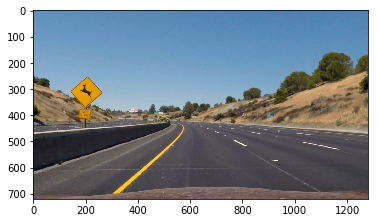

In [17]:
#demo undistortion

unDist=cv2.undistort(mpimg.imread("test_images/test2.jpg"), mtx, dist, None, mtx)
plt.imsave('output_images/unDist.jpg',unDist)
plt.imshow(unDist)

In [18]:
#load all 6 test images into memory

im1=mpimg.imread("test_images/test1.jpg")
im2=mpimg.imread("test_images/test2.jpg")
im3=mpimg.imread("test_images/test3.jpg")
im4=mpimg.imread("test_images/test4.jpg")
im5=mpimg.imread("test_images/test5.jpg")
im6=mpimg.imread("test_images/test6.jpg")
imS=mpimg.imread("test_images/straight_lines1.jpg")

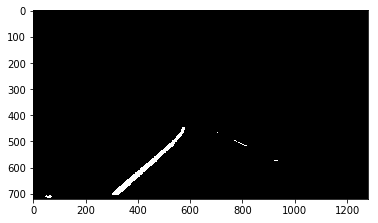

In [ ]:
#demo thresholding

im2seg=process_frameNW(im2,mtx,dist)
cv2.imwrite('output_images/seg2NW.jpg',im2seg)
plt.imshow(im2seg,cmap='gray')

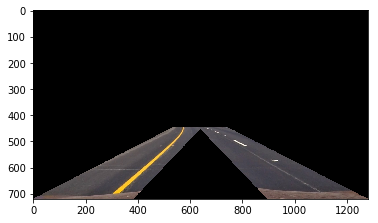

In [ ]:
#demo masking

r_size=len(im2) #get size of image
c_size=len(im2[0])
imageUD= cv2.undistort(im2, mtx, dist, None, mtx) #undistort image


#long array that contains vertices for mask/region of interest
vertices=np.array([[(int(c_size*1-1), r_size-1),(int(c_size*0.70-1),r_size-1),(int(c_size*0.5-1),int(r_size*.63)-1),(int(c_size*0.30-1),r_size-1),(int(c_size*0.00-1),r_size-1),(int(c_size*.42-1),int(r_size*0.62-1)),(int(c_size*.58-1),int(r_size*0.62-1))]])
    

im2mask=region_of_interest(imageUD,vertices)
plt.imshow(im2mask)
plt.imsave('output_images/masked.jpg',im2mask)

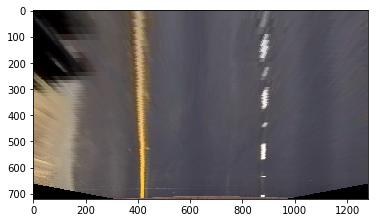

In [ ]:
#demo warp with straight line

#demo masking

imageUD= cv2.undistort(imS, mtx, dist, None, mtx) #undistort image


#long array that contains vertices for mask/region of interest
vertices=np.array([[(int(c_size*1-1), r_size-1),(int(c_size*0.70-1),r_size-1),(int(c_size*0.5-1),int(r_size*.63)-1),(int(c_size*0.30-1),r_size-1),(int(c_size*0.00-1),r_size-1),(int(c_size*.42-1),int(r_size*0.62-1)),(int(c_size*.58-1),int(r_size*0.62-1))]])
    

imSwarped=warp(imageUD)
plt.imshow(imSwarped)
plt.imsave('output_images/warp.jpg',imSwarped)

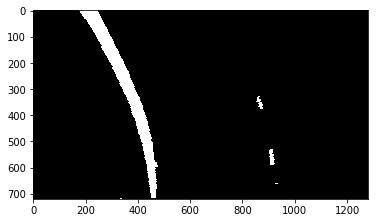

In [ ]:
#demo bird's eye transformation of thresholded images

im2seg=process_frame(im2,mtx,dist)
cv2.imwrite('output_images/seg2.jpg',im2seg)
plt.imshow(im2seg,cmap='gray')

radius of curvature in feet
1037.918314369202

offset in lane in feet with left offset being positive:
1.5270225349978093


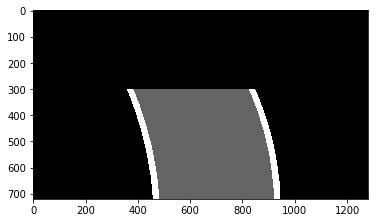

In [ ]:
#demo polynomials fitted to thresholded images
resetGlobals()
[mp2, al, bl, cl, ar, br, cr]=drawMidpoint(im2seg,al,bl,cl,ar,br,cr)
plt.imshow(mp2,cmap='gray')
cv2.imwrite('output_images/mp2.jpg',mp2)

#demo radius of curvature calculation
print('radius of curvature in feet')
print(curvature(al,bl,ar,br,720))

print()

#demo offset calculation
print('offset in lane in feet with left offset being positive:')
print(laneOffset(al, bl, cl, ar, br, cr,720))

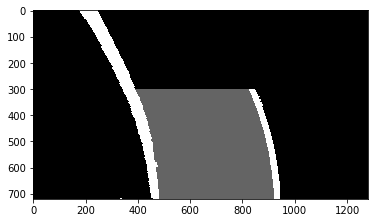

In [ ]:
#show parabolas overlaid on thresholded image

overlayIm=cv2.addWeighted(mp2, 1, im2seg, 1,0)
cv2.imwrite('output_images/overlay.jpg',overlayIm)
plt.imshow(overlayIm,cmap='gray')

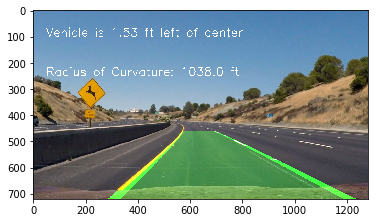

In [ ]:
resetGlobals()
doAll2im=doAll(im2,mtx,dist) #show process from beginning to end
plt.imsave('output_images/doAll.jpg',doAll2im)
plt.imshow(doAll2im)

In [ ]:
resetGlobals()
#run on video
clip1=VideoFileClip('project_video.mp4')
clip1out='project_video_out.mp4'
testClip=clip1.fl_image(lambda image: doAll(image,mtx,dist))
%time testClip.write_videofile(clip1out, audio=False)


[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


  5%|███▋                                                                            | 58/1261 [00:14<04:57,  4.04it/s]

In [ ]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(clip1out))